**About the Competition:**

[Avito](https://www.avito.ru/), Russia’s largest classified advertisements website, is hosting its fourth Kaggle competition. The challenge is to predict demand for an online advertisement based on its full description (title, description, images, etc.), its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts. 

**About the Notebook:**

One more exciting competition ahead and this involves both NLP (text data in Russian) and Image data along with numerical . In this notebook, let us get into the basic data exploration using python. 

Thanks to [Yandex Translate](https://translate.yandex.com/), I was able to get english names for the russian names and used them whenever possible. Most of the plots are in plotly and so please hover over them to see more details. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

The description of the data files from the data page:

* train.csv - Train data.
* test.csv - Test data. Same schema as the train data, minus deal_probability.
* train_active.csv - Supplemental data from ads that were displayed during the same period as train.csv. Same schema as the train data, minus deal_probability.
* test_active.csv - Supplemental data from ads that were displayed during the same period as test.csv. Same schema as the train data, minus deal_probability.
* periods_train.csv - Supplemental data showing the dates when the ads from train_active.csv were activated and when they where displayed.
* periods_test.csv - Supplemental data showing the dates when the ads from test_active.csv were activated and when they where displayed. Same schema as periods_train.csv, except that the item ids map to an ad in test_active.csv.
* train_jpg.zip - Images from the ads in train.csv.
* test_jpg.zip - Images from the ads in test.csv.
* sample_submission.csv - A sample submission in the correct format.

Let us start with the train file.

In [2]:
train_df = pd.read_csv("../avito_demand.csv", parse_dates=["activation_date"])

In [3]:
train_df.head()

,city,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,deal_probability,region,parent_category_name,category_name
0,Екатеринбург,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,0.12789,Sverdlovsk oblast,Personal belongings,Children's products and toys
1,Самара,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,0.00000,Samara oblast,For the home and garden,Furniture and interior
2,Ростов-на-Дону,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,0.43177,Rostov oblast,Consumer electronics,Audio and video
3,Набережные Челны,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,0.80323,Tatarstan,Personal belongings,Children's products and toys
4,Волгоград,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,0.20797,Volgograd oblast,Transport,Cars


The train dataset description is as follows:

* item_id - Ad id.
* user_id - User id.
* region - Ad region.
* city - Ad city.
* parent_category_name - Top level ad category as classified by Avito's ad model.
* category_name - Fine grain ad category as classified by Avito's ad model.
* param_1 - Optional parameter from Avito's ad model.
* param_2 - Optional parameter from Avito's ad model.
* param_3 - Optional parameter from Avito's ad model.
* title - Ad title.
* description - Ad description.
* price - Ad price.
* item_seq_number - Ad sequential number for user.
* activation_date- Date ad was placed.
* user_type - User type.
* image - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.
* image_top_1 - Avito's classification code for the image.
* deal_probability - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.

So deal probability is our target variable and  is a float value between 0 and 1 as per the data page. Let us have a look at it. 

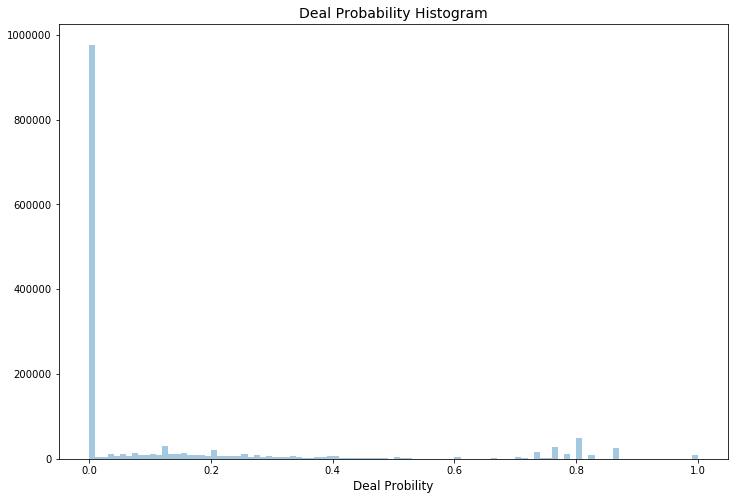

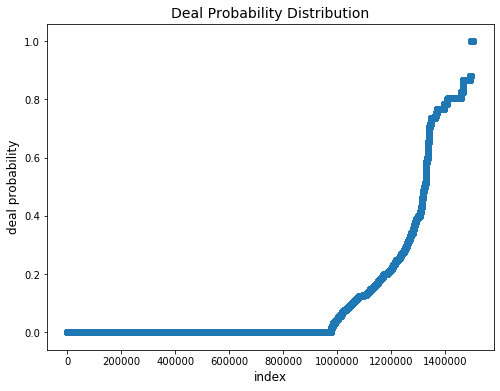

In [4]:
plt.figure(figsize=(12,8))
sns.distplot(train_df["deal_probability"].values, bins=100, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['deal_probability'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('deal probability', fontsize=12)
plt.title("Deal Probability Distribution", fontsize=14)
plt.show()

So almost 100K Ads has 0 probaility (which means it did not sell anything) and few ads have a probability of 1. Rest of the deal probabilities have values in between. 

**Region wise distribution of Ads:**

Let us look at the region wise distribution of ads. 

In [5]:
temp_series = train_df['region'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Region distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="region")

The regions have percentage of ads between 1.71% to 9.41%. So the top regions are:
1. Krasnodar region - 9.41%
2. Sverdlovsk region - 6.28%
3. Rostov region - 5.99%


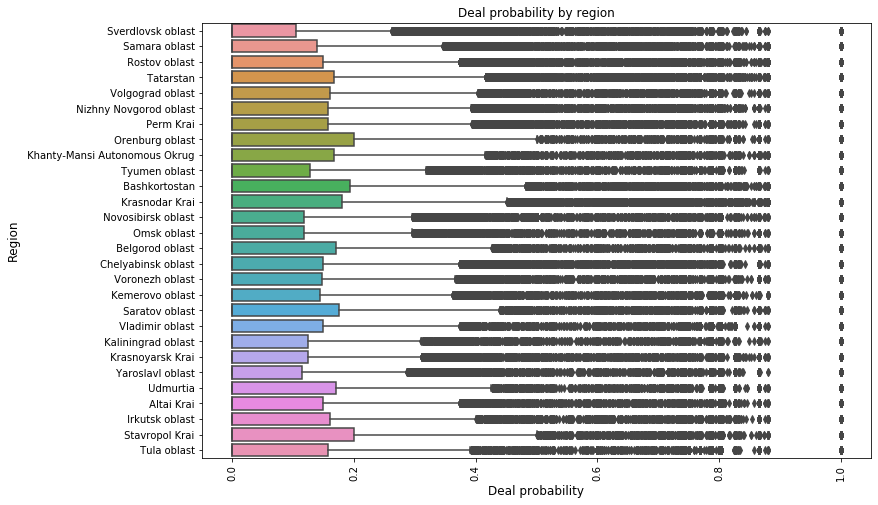

In [6]:
plt.figure(figsize=(12,8))
sns.boxplot(y="region", x="deal_probability", data=train_df)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title("Deal probability by region")
plt.xticks(rotation='vertical')
plt.show()

**City wise distribution of Ads:**

Now let us have a look at the top 20 cities present in the dataset.

In [7]:
cnt_srs = train_df['city'].value_counts().head(20)
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='City distribution of Ads',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="CityAds")

So the top cities where the ads are shown are
1. Krasnodar
2. Ekaterinburg
3. Novosibirsk

**Parent Category Name:**

Now let us look at the distribution of parent cateory names.

In [8]:
temp_series = train_df['parent_category_name'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Parent Category distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="parentcategory")

1So 46.4% of the ads are for Personal belongings, 11.9% are for home and garden and 11.5% for consumer electronics.

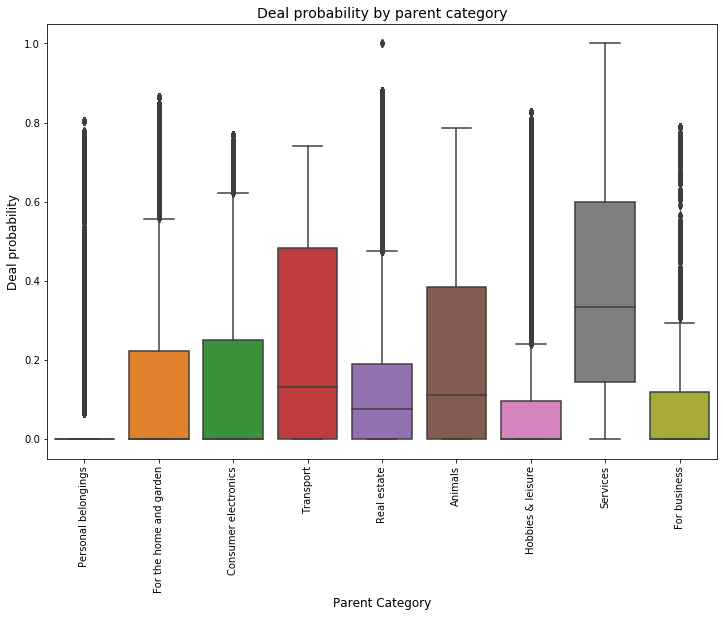

In [9]:
plt.figure(figsize=(12,8))
sns.boxplot(x="parent_category_name", y="deal_probability", data=train_df)
plt.ylabel('Deal probability', fontsize=12)
plt.xlabel('Parent Category', fontsize=12)
plt.title("Deal probability by parent category", fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

Services category seems to have slightly higher deal probability compared to others. 

** Category of Ads:**

Now let us look at the category of ads.

In [10]:
cnt_srs = train_df['category_name'].value_counts()
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='Category Name of Ads - Count',
    height=900
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="category name")

So the top 3 categories are:
1. Clothes, shoes, accessories
2. Children's clothing and footwear
3. Goods for children and toys


** User Type:**

Now let us look at the user type. 

In [11]:
temp_series = train_df['user_type'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='User Type distribution',
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

Private users constitute 72% of the data followed by company and shop.

**Price:**

This is the price shown in the Ad. 

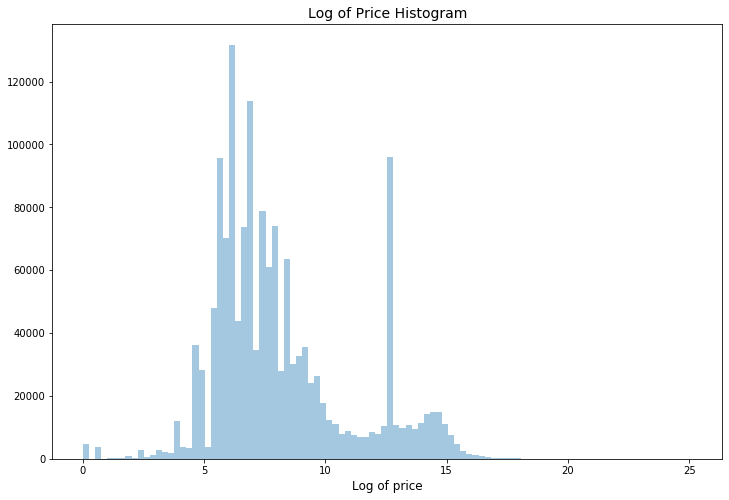

In [12]:
train_df["price_new"] = train_df["price"].values
train_df["price_new"].fillna(np.nanmean(train_df["price"].values), inplace=True)

plt.figure(figsize=(12,8))
sns.distplot(np.log1p(train_df["price_new"].values), bins=100, kde=False)
plt.xlabel('Log of price', fontsize=12)
plt.title("Log of Price Histogram", fontsize=14)
plt.show()

**Activation Date:**

In [13]:
cnt_srs = train_df['activation_date'].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Activation Dates in Train'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Activation Dates in Test'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In [14]:
train_df["title_nwords"] = train_df["title"].apply(lambda x: len(x.split()))
cnt_srs = train_df['title_nwords'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in title column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="title_nwords")           

In [15]:
## Filling missing values ##
train_df["description"].fillna("NA", inplace=True)
train_df["desc_nwords"] = train_df["description"].apply(lambda x: len(x.split()))

cnt_srs = train_df['desc_nwords'].value_counts().head(100)

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in Description column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="desc_nwords")  